In [1]:
from data_stream import StreamReceiver

from simulation.webots.controllers.ardupilot_vehicle_controller.drone_data import RangefinderData, CameraData, FDMData, GimbalAxisData, GimbalData, DroneData
from mavlink.mavlink import MAVLinkController, DataAcquisitionThread
from mavlink.mavlink.processor import DataProcessor, GimbalProcessor, GlobalPositionProcessor, AttitudeProcessor

import cv2


mavlink_connection = MAVLinkController("udp:0.0.0.0:14550")

attitude_processor = AttitudeProcessor()
gimbal_processor = GimbalProcessor()

acquisition_thread = DataAcquisitionThread(mavlink_connection, [attitude_processor, gimbal_processor])
acquisition_thread.start()

In [2]:
from data_stream import StreamReceiver

from simulation.webots.controllers.ardupilot_vehicle_controller.drone_data import RangefinderData, CameraData, FDMData, GimbalAxisData, GimbalData, DroneData
import cv2


host = "192.168.0.107"
port = 5588
stream_receiver = StreamReceiver(host, port)

In [23]:
import math


latest_data = gimbal_processor.queue.get_latest()
if latest_data:
    print("GIMBAL", [axis for axis in latest_data.quaternion.to_euler()])


GIMBAL [0.0, -0.17453291746170088, 0.0]


In [4]:
mavlink_connection.gimbal.set_angles(
    roll=0,
    pitch=-10,
    yaw=0
)

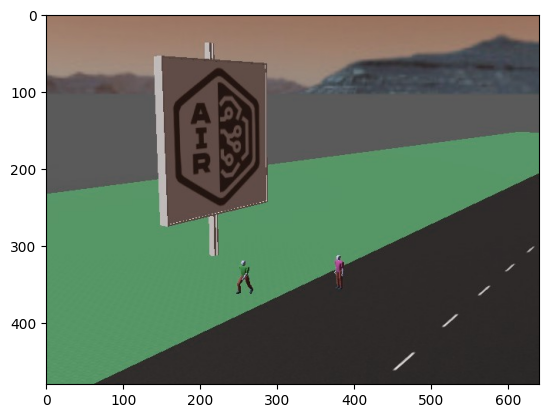

In [5]:
from matplotlib import pyplot as plt


data = stream_receiver.get_data()
drone_data = DroneData.from_json(data)
camera_frame = drone_data.camera.frame

gimbal_status = gimbal_processor.queue.get_latest()

plt.imshow(camera_frame)
plt.show()

In [6]:
from ultralytics import YOLO
import random
from deep_sort.deep_sort.tracker import Tracker
from deep_sort.deep_sort.deep.extractor import Extractor
from deep_sort.deep_sort.deep.configuration import ResNetConfiguration
from deep_sort.deep_sort.deep.weights import RESNET18_WEIGHTS


model = YOLO("yolov8n.pt")

detection_threshold = 0.01

resnet = ResNetConfiguration(
    base="resnet18",
    weights_path=RESNET18_WEIGHTS,
    use_cuda=True
)
extractor = Extractor(model=resnet, batch_size=4)

tracker = Tracker(
    feature_extractor=extractor
)

colors = [(
    random.randint(0, 255),
    random.randint(0, 255),
    random.randint(0, 255)) for j in range(10)
]

In [19]:
results = model.predict(
        camera_frame,
        verbose=False
    )
result = results[0]

Target:
	class_id: 0
	score: 0.7484198212623596
	x1 y1 x2 y1: [373, 312, 388, 358]
Target:
	class_id: 0
	score: 0.6433892250061035
	x1 y1 x2 y1: [246, 318, 270, 364]


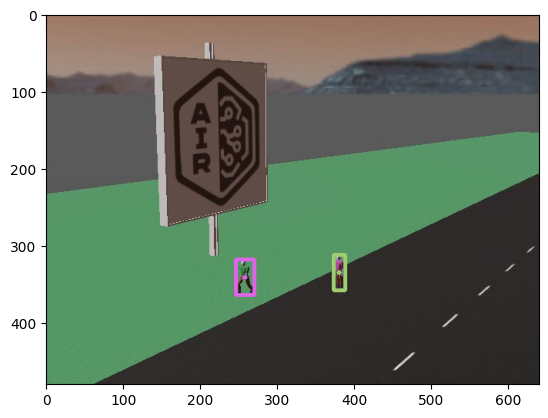

In [20]:
print_frame = camera_frame.copy()
for i, result in enumerate(result.boxes.data.tolist()):    
    x1, y1, x2, y2, score, class_id = result
    x1 = int(x1)
    x2 = int(x2)
    y1 = int(y1)
    y2 = int(y2)
    class_id = int(class_id)

    print(f"Target:\n"
          f"\tclass_id: {class_id}\n"
          f"\tscore: {score}\n"
          f"\tx1 y1 x2 y1: {[x1, y1, x2, y2]}")

    color = colors[i % len(colors)]

    cv2.rectangle(
        print_frame,
        (int(x1), int(y1)),
        (int(x2), int(y2)),
        color,
        3
    )
    
    cx = int((x1 + x2) / 2)
    cy = int((y1 + y2) / 2)
    
    cv2.circle(
        print_frame,
        (cx, cy),
        3,
        color,
        -1
    )
        
plt.imshow(print_frame)
plt.show()

In [10]:
print(drone_data.camera)
print(gimbal_status.quaternion.to_euler(), [math.degrees(axis) for axis in gimbal_status.quaternion.to_euler()])

CameraData(timestamp=2417.6820000000002, width=640, height=480, fps=30.303030303030305, fov=0.785, data_type='uint8')
(0.0, -0.6108652047804638, 0.0)
[0.0, -34.99999808531533, 0.0]


In [22]:
from math import atan, tan, radians, degrees


fov_vertical = 2 * atan(tan(drone_data.camera.fov * 0.5) * (drone_data.camera.height / drone_data.camera.width))

x1, y1, x2, y2 = 373, 312, 388, 358

target_center_x = (x1 + x2) / 2
target_center_y = (y1 + y2) / 2

image_center_x = drone_data.camera.width / 2
image_center_y = drone_data.camera.height / 2

offset_x = target_center_x - image_center_x
offset_y = target_center_y - image_center_y

offset_x_radians = (offset_x / drone_data.camera.width) * drone_data.camera.fov
offset_y_radians = (offset_y / drone_data.camera.height) * fov_vertical

print(offset_x, offset_y)
print(offset_x_radians, offset_y_radians)

60.5 95.0
0.07420703125 0.11916496069500794


In [26]:
mavlink_connection.gimbal.set_angles(
    roll=0,
    pitch=degrees(-0.17453291746170088 - offset_y_radians),
    yaw=degrees(offset_x_radians)
)

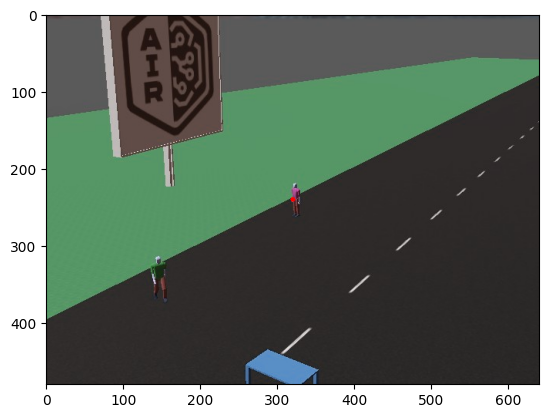

In [30]:
new_data = stream_receiver.get_data()
new_drone_data = DroneData.from_json(new_data)
new_camera_frame = new_drone_data.camera.frame

new_gimbal_status = gimbal_processor.queue.get_latest()

cv2.circle(
    new_camera_frame,
    (int(new_drone_data.camera.width / 2), int(new_drone_data.camera.height / 2)),
    3,
    (255, 0, 0),
    -1
)

plt.imshow(new_camera_frame)
plt.show()